In [1]:
import heapq
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='../library/heiti.ttf', size=12)
import matplotlib.cm as cm
import skimage.transform
import argparse
#from scipy.misc import imresize
from imageio import imread
from PIL import Image
print("torch.version=", torch.__version__)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("device=",device)

torch.version= 1.7.0+cu101
device= cuda:1


In [2]:
main_name1 = "flickr30kzh_5_cap_per_img_5_min_word_freq_seg_based"
main_name2 = "flickr30kzh_5_cap_per_img_5_min_word_freq_char_based"
main_name3 = "flickr8kzh_5_cap_per_img_5_min_word_freq_seg_based"
main_name4 = "flickr8kzh_5_cap_per_img_5_min_word_freq_char_based"

#VGG19 = "VGG19_"
VGG19 = ''
ft = "_fine_tune"
#ft = ''
model1 = "../checkpoints/BEST_checkpoint_" + VGG19 + main_name1 + ft + ".pth.tar"
model2 = "../checkpoints/BEST_checkpoint_" + VGG19 + main_name2 + ft + ".pth.tar"
model3 = "../checkpoints/BEST_checkpoint_" + VGG19 + main_name3 + ft + ".pth.tar"
model4 = "../checkpoints/BEST_checkpoint_" + VGG19 + main_name4 + ft + ".pth.tar"

word_map1 ="../prepared_data/WORDMAP_" + main_name1 + ".json"
word_map2 ="../prepared_data/WORDMAP_" + main_name2 + ".json"
word_map3 ="../prepared_data/WORDMAP_" + main_name3 + ".json"
word_map4 ="../prepared_data/WORDMAP_" + main_name4 + ".json"

beam_width = 3

In [3]:
def read_image_and_resize(image_path):
    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    #img = imresize(img, (256, 256))
    img = np.array(Image.fromarray(img).resize((256,256), Image.BICUBIC))
    
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)
    return image

In [4]:
class beam():
    def __init__(self, beam_width=5):
        self.heap = list()
        self.beam_width = beam_width
        
    def add(self, prob, complete, seq, alphas, inputs, h, c):
        heapq.heappush(self.heap, [prob, complete, seq, alphas, inputs, h, c])
        if len(self.heap) > self.beam_width:
            heapq.heappop(self.heap)
    
    def __iter__(self):
        return iter(self.heap)

In [5]:
def decode(decoder, encoder_out, encoder_dim, enc_image_size, word_map_start, word_map_end, beam_width):
    """Generate one sample"""
    batch_size = 1
    inputs = torch.Tensor([word_map_start]).long().to(device)
    h, c = decoder.init_hidden_state(encoder_out)
    alphas = torch.ones(1, enc_image_size, enc_image_size).to(device)
    prev_beam = beam(beam_width)
    prev_beam.add(1, False, [word_map_start], alphas, inputs, h, c)
    while True:
        cur_beam = beam()
        for _prob, _complete, _seq, _alphas, _inputs, _h, _c in prev_beam:
            if _complete == True:
                cur_beam.add(_prob, _complete, _seq, _alphas, _inputs, _h, _c)
            else:
                embeddings = decoder.embedding(_inputs)  # (1, embed_dim)
                awe, alpha = decoder.attention(encoder_out, _h)  # (1, encoder_dim), (1, num_pixels)
                alpha = alpha.view(-1, enc_image_size, enc_image_size) # (1, enc_image_size, enc_image_size)
                gate = decoder.sigmoid(decoder.f_beta(_h))  # gating scalar, (1, encoder_dim)
                awe = gate * awe
                h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (_h, _c))
                score = decoder.fc(h)  # (1, vocab_size)
                preds = F.softmax(score, dim=1)
                value, pred = torch.topk(preds.view(-1),beam_width)
                for m, n in zip(value, pred):
                    next_input = n.item()
                    inputs = torch.Tensor([next_input]).long().to(device)
                    seq = _seq + [n.item()]
                    prob = _prob * m.item()
                    alphas = torch.cat((_alphas, alpha), dim=0)
                    if n.item() == word_map_end:
                        complete = True
                    else:
                        complete = False
                    cur_beam.add(prob, complete, seq, alphas, inputs, h, c)
        best_prob, best_complete, best_seq, best_alphas, _, _, _ = max(cur_beam)
        if best_complete == True:
            return best_seq, best_alphas
        else:                
            prev_beam = cur_beam

In [6]:
def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_width=5):
    """
    Reads an image and captions it with beam search.
    
    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """
    vocab_size = len(word_map)
    word_map_start = word_map['<start>']
    word_map_end = word_map['<end>']

    # Read image and process
    image = read_image_and_resize(image_path)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)
    
    # Decode
    seq, alphas = decode(decoder, encoder_out, encoder_dim, enc_image_size, word_map_start, word_map_end, beam_width)
    return seq, alphas

In [7]:
def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]
    fig = plt.figure(figsize=(20, 5))
    for t in range(len(words)):
        if t > 50:
            break
        
        plt.subplot(np.ceil(len(words) / 10.), 10, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12, fontproperties=font)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.detach().numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.detach().numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

In [11]:
def run():

    for x in [[model1, word_map1],[model2, word_map2],[model3, word_map3],[model4, word_map4]]:
        model, word_map = x
        # Load model
        checkpoint = torch.load(model, map_location=str(device))
        decoder = checkpoint['decoder']
        decoder = decoder.to(device)
        decoder.eval()
        encoder = checkpoint['encoder']
        encoder = encoder.to(device)
        encoder.eval()

        # Load word map (word2ix)
        with open(word_map, 'r') as j:
            word_map = json.load(j)
        rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

        # Encode, decode with attention and beam search
        seq, alphas = caption_image_beam_search(encoder, decoder, img, word_map, beam_width)
        alphas = torch.FloatTensor(alphas.to("cpu"))

        decoded_seq = []
        for item in seq:
            decoded_seq.append(rev_word_map[item])
        print(decoded_seq)

        # Visualize caption and attention of best sequence
        visualize_att(img, seq, alphas, rev_word_map, smooth=False)

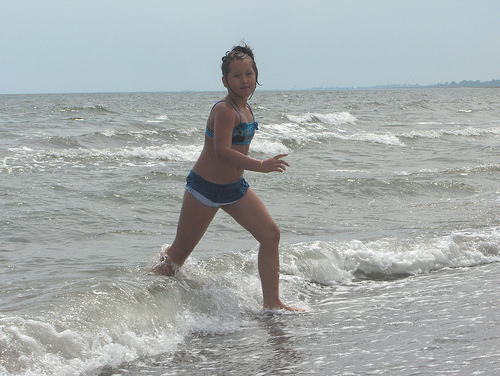

['<start>', '一个', '穿', '着', '蓝色', '泳衣', '的', '年轻', '女孩', '在', '水中', '玩耍', '<end>']


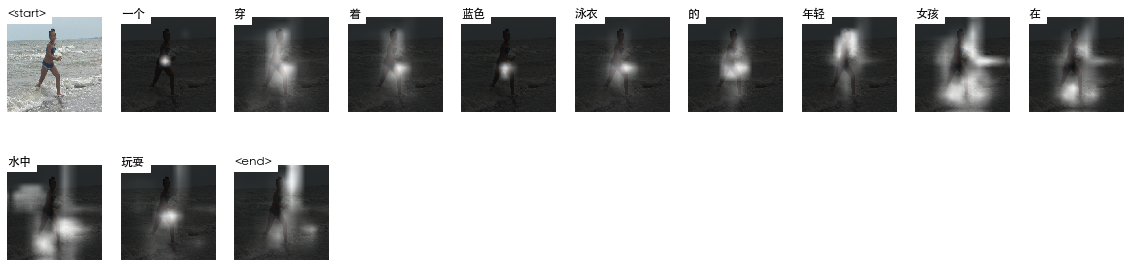

['<start>', '一', '个', '穿', '着', '泳', '衣', '的', '女', '孩', '在', '沙', '滩', '上', '奔', '跑', '<end>']


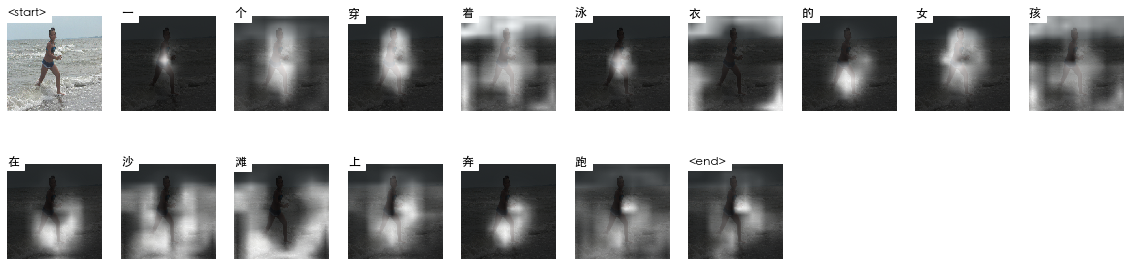

['<start>', '一个', '穿', '着', '泳衣', '的', '小', '男孩', '站', '在', '沙滩', '上', '<end>']


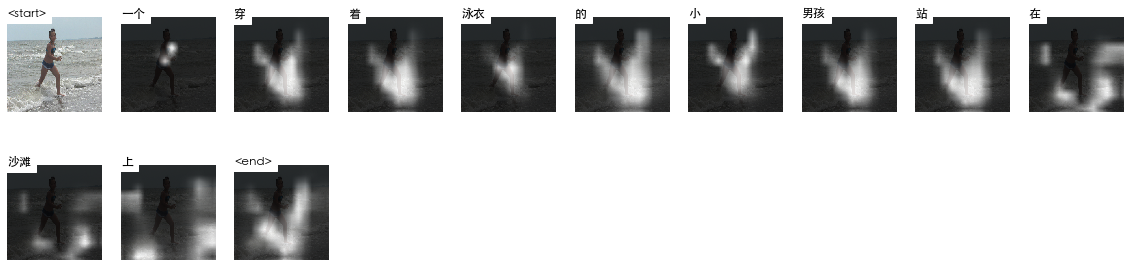

['<start>', '一', '个', '小', '男', '孩', '在', '海', '滩', '上', '玩', '耍', '<end>']


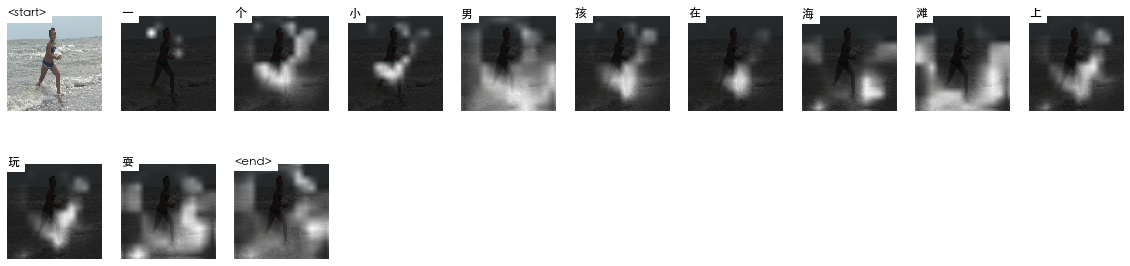

In [12]:
import os
import random
from IPython.display import Image as DisplayImage
directory = '../data/flickr30k_images/'
#directory = '../data/images/test/'
#directory = '../testimage/'
for filename in random.sample(os.listdir(directory), 1):
    if filename.endswith("jpg") == False: continue
    #img = "../data/flickr8k_images/"+str(line)[0:-2]+".jpg"
    img=directory+filename
    display(DisplayImage(img, width=150, height=150))
    run()